# Inverse Filter and Wiener Filter
> 0712238 Yan-Tong Lin, for DIP2021spring HW5

## DIP Homework Chapter 5
1. Please use Inverse Filter and Wiener Filter to correct the image corrupted severe turbulence of the assigned image, ‘Fig5.25.jpg’, and print out the source code and the corrected image. (40)
2. Please use Inverse Filter and Wiener Filter to correct the image corrupted by motion blur of the assigned image, ‘book-cover-blurred.tif’, and print out the source code and the corrected image? (40)
3. Please comment and compare your two design filters? (20) 

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scipy import signal
from scipy import misc
import cv2 as cv
from numpy import fft

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
cv.__version__

'4.5.1'

## Solution Sketch
* Main idea
    * Use inverse filters/Wiener filters to correct the images corrupted by turbulence/motion blur.
    * $f \overset{\star h}{\to} g \overset{\text{restoration}}{\to} \hat f$
* Remark
    * In this report, a capital charater means the Fourier representation of its lowercase version
    * We deal with the BGR channels seperately and then merge them together. However, for simplicity, only the process of the first channel is visualized.

### Degeneration Model for Problem 1
* $H = e^{-k(r^2)^{\frac 5 6}}$ where $r = (u-N/2)^2+(v-M/2)^2$
    * we take $k=0.0025$

### Degeneration Model for Problem 2 
* $H = T\text{sinc}(d)e^{-i\pi d}$ where $d = au+bv, \text{sinc}(x)=\frac{\sin \pi x}{\pi x}$
    * we take $a=b=0.1, T=1$

### Three Filters Methods
- Inverse Filtering
    - the most direct and naive way
    - $\hat F = G/H$
    - may need to cut close to zero value
        - or $\hat F = F + N/H$ and $N/H$ will dominate $F$
- Radially Limited Inverse Filtering
    - Inverse Filtering, but apply $/H$ only on the low frequency part
- Wiener Filtering
    - i.e. Min MSE Filtering
    - $\hat F = \frac{1}{H}\frac{|H|^2}{|H|^2+K}G$
    - $K$ is taken to estimate $\text{SNR}$(signal noise ratio)

### Comparison
- Inverse Filtering
    - the worst, the resulted images are dominated by the amplified noise
- Radially Limited Inverse Filtering
    - better, but can still see some artifacts
- Wiener Filtering
    - of the best quality (P1: less artifacts, P2: can recognize "Digital Image Processing")

## Some Ancillary Functions

In [17]:
# Utilities
def normed(img): # input should be cv matrix
    return cv.normalize(img, img, 0, 1., cv.NORM_MINMAX)

def my_fft(img, shift=True):
    if(shift):
        return fft.fftshift(fft.fft2(img))
    else:
        return fft.fft2(img)

def my_ifft(img, shift=True):
    if(shift):
        return fft.ifft2(fft.ifftshift(img))
    else:
        return fft.ifft2(img)
    
def inverse(img, H, shift=True):
    # direct inverse filtering
    G = my_fft(img, shift)
    # plt.imshow(np.abs(G))
    F_hat = G/H
    # plt.imshow(np.abs(F_hat))
    result = my_ifft(F_hat, shift)
    result = np.abs(result)
    return result

def inverse_rad(img, H, rad, pad=1, shift=True):
    # radius limited inverse filtering
    # use the naive one to cut, advanced radius cutting is not required
    G = my_fft(img, shift)
    # plt.imshow(np.abs(G))
    r,c = H.shape
    H2 = np.ones((r,c))
    for i in range(r):
        for j in range(c):
            if shift:
                d = (i-r/2)*(i-r/2)+(j-c/2)*(j-c/2)
            else:
                d = np.pi*0.1*(i+j)
            H2[i][j] = H[i][j] if d < (rad*rad) else pad
    F_hat = G/H2
    # plt.imshow(np.abs(F_hat))
    result = my_ifft(F_hat, shift)
    result = np.abs(result)
    return result

def wiener(img, H, K=0.01, shift=True):
    # Wiener filtering
    G = my_fft(img, shift)
    H2 = np.conj(H)/(np.abs(H)*np.abs(H) + K) # 1/H * |H|^2/(|H|^2+K)
    F_hat = G*H2
    result = my_ifft(F_hat, shift)
    #print(type(result[0][0])) # => numpy.complex128
    result = np.abs(result)
    #print(type(result[0][0])) # => numpy.float64
    return result

def exp(img_name, H, rad, pad, K, shift=True):
    # img_name = name of image
    # H = the degeneration model
    # rad, pad = radius and padding for inverse filter cutting
    # K = estimated SRN for Wiener filtering
    img_original = cv.imread(img_name, 1)
    channels = cv.split(img_original)
    channels_result = []
    
    for ci in range(len(channels)):
        img = channels[ci]
        img_inv = inverse(img, H, shift)
        img_inv_rad = inverse_rad(img, H, rad, pad, shift)
        img_MSE = wiener(img, H, K, shift)
        channels_result += [img_MSE]
        # Display
        if(ci == 0):
            n_plots = 4
            titles = ['original', 'full inverse', 'radially limited inverse', 'Wiener']
            images = [img, img_inv, img_inv_rad, img_MSE]
            fig, axs = plt.subplots(1, n_plots, figsize=[15, 15])
            for i in range(len(titles)):
                axs[i].imshow(images[i], 'gray')
                axs[i].set_title(titles[i])
                axs[i].set_xticks([]), axs[i].set_yticks([])
            plt.show()
    result = cv.merge(channels_result)
    return normed(result)

(291, 288, 3)
(688, 688, 3)


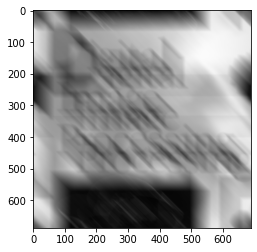

In [18]:
img_name = "Fig5.25.jpg"
img_name2 = "book-cover-blurred.tif"
img = cv.imread(img_name)
img2 = cv.imread(img_name2)
print(img.shape)
print(img2.shape)
plt.imshow(img)
plt.imshow(img2)

## Problem 1 --- 'Fig5.25.jpg'

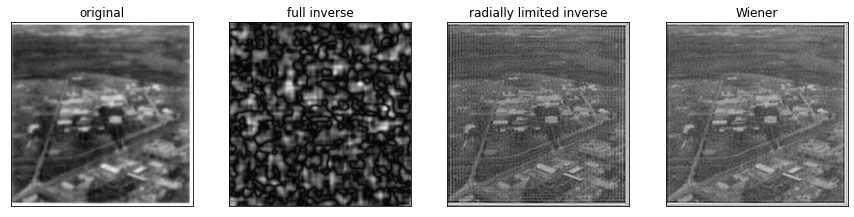

In [19]:
def get_H1(k):
    r, c = 291, 288
    H = np.zeros((r,c), dtype = 'complex_')
    for i in range(r):
        for j in range(c):
            d = (i-r/2)**2+(j-c/2)**2
            H[i][j] = np.exp(-k*pow(d, 5/6))
    return H


H = get_H1(k = 0.0025)
_ = exp("Fig5.25.jpg", H, rad=60, pad = 1, K=0.01, shift=True)

## Problem 2 --- 'book-cover-blurred.tif'

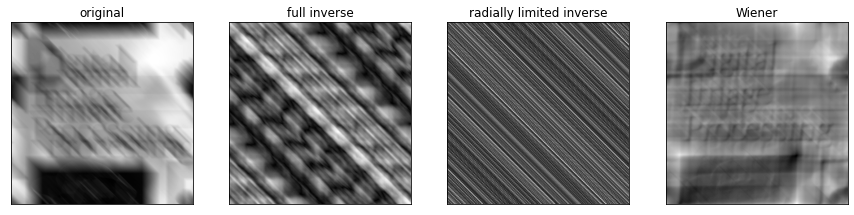

In [20]:
def get_H2(a, b, T=1, eps = 1e-10):
    r, c = 688, 688
    H = np.zeros((r,c), dtype = 'complex_')
    for u in range(r):
        for v in range(c):
            d = ((u)*a+(v)*b)
            d = eps if d < eps else d
            H[u][v] = (T)*(np.sinc(d)*np.exp(-1j*np.pi*d)) # sinc(x) = sin pi x / pi x
            H[u][v] = eps if np.abs(H[u][v]) < eps else H[u][v]
    return H

H2 = get_H2(a = 0.1, b = 0.1, T = 1, eps = 1e-10)
_ = exp("book-cover-blurred.tif", H2, rad=10, pad = 1, K=0.01, shift=False)